# Identifying Animal Crossing or Doom in Reddit Posts

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

### Reading in training and testing sets as well as TensorFlow Image Predictions 

In [2]:
train = pd.read_csv('train.csv')
train_pred = pd.read_csv('TrainPred.csv')

In [3]:
test = pd.read_csv('test.csv')
test_pred = pd.read_csv('TestPred.csv')

In [4]:
#Looking at predictions column names
train_pred.head()

,File,AnimalCrossingWeights,DoomWeights
0,003kprvwysr41.jpg,-0.281085,0.430738
1,0177myxmpiq41.jpg,-0.281240,0.430935
2,01vmlf4buap41.jpg,-0.105872,0.210422
3,04z5q0nunyt41.png,-0.281240,0.430935
4,05tmnohw0qn41.png,0.051152,0.013550


## Natural Language Processing on the posting titles

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import chi2, SelectKBest

### Create Functions to determine top words associated with each type of image

In [6]:
# Get top n tfidf values in row and return them with their corresponding feature names.
def top_tfidf_feats(row, features, top_n=25):
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

In [7]:
# Top tfidf features in specific document (matrix row)
def top_feats_in_doc(Xtr, features, row_id, top_n=25):
    row = np.squeeze(Xtr[row_id].toarray())
    return top_tfidf_feats(row, features, top_n)

In [8]:
def top_mean_feats(Xtr, features, grp_ids=None, min_tfidf=0.1, top_n=25):
    if grp_ids:
        D = Xtr[grp_ids].toarray()
    else:
        D = Xtr.toarray()

    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0)
    return top_tfidf_feats(tfidf_means, features, top_n)

In [9]:
def top_feats_by_class(Xtr, y, features, min_tfidf=0.1, top_n=25):
    dfs = []
    labels = np.unique(y)
    for label in labels:
        ids = np.where(y==label)
        feats_df = top_mean_feats(Xtr, features, ids, min_tfidf=min_tfidf, top_n=top_n)
        feats_df.label = label
        dfs.append(feats_df)
    return dfs

In [10]:
!pip install nltk
import nltk
#nltk.download('vader_lexicon')
#nltk.download('stopwords')

### Create a list of stop words to ignore

In [11]:
from nltk.corpus import stopwords
stop = list(stopwords.words('english'))

#Add aditional stop words that would potentially overfit the model
stop.extend('doom animal crossing doomguy bethesda id'.split())

### Create the vectorizer to analyse the text

In [12]:
tfidf_vectorizer = TfidfVectorizer(analyzer='word',stop_words= set(stop))

### Create the vector that reads the text on the image

In [13]:
tfidf_vector = tfidf_vectorizer.fit_transform(train['title'])
tfidf_vector

<1277x2572 sparse matrix of type '<class 'numpy.float64'>'
	with 5839 stored elements in Compressed Sparse Row format>

### Convert the vector into a Data Frame with all the words as features

In [14]:
tfidf_df = pd.DataFrame(tfidf_vector.toarray(), columns=tfidf_vectorizer.get_feature_names())
tfidf_df

,000,03,10,100,10000,100k,101,11,1100,1176,...,yum,yup,zen,zieguy,zombie,zombies,zoo,zucker,ａｅｓｔｈｅｔｉｃ,ｃｒｏｓｓｉｎｇ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1273,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1274,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1275,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Fine the top 15 words associated with each image. We can make those words into features and take the vector values from the selected words as new data points for our model.

In [15]:
dfs = top_feats_by_class(tfidf_vector,train['subreddit'],tfidf_vectorizer.get_feature_names(),top_n=15)

### Visualize the top 15 features associated with both Classifications

In [16]:
import matplotlib.pyplot as plt

# Plot the data frames returned by the function plot_tfidf_classfeats().
def plot_tfidf_classfeats_h(dfs):
    fig = plt.figure(figsize=(30, 9), facecolor="w")
    x = np.arange(len(dfs[0]))
    for i, df in enumerate(dfs):
        ax = fig.add_subplot(1, len(dfs), i+1)
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)
        ax.set_frame_on(False)
        ax.get_xaxis().tick_bottom()
        ax.get_yaxis().tick_left()
        ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=25)
        ax.set_title("label = " + str(df.label), fontsize=30)
        ax.ticklabel_format(axis='x', style='sci', scilimits=(-2,2))
        ax.barh(x, df.tfidf, align='center', color='#005035')
        ax.set_yticks(x)
        ax.set_ylim([-1, x[-1]+1])
        yticks = ax.set_yticklabels(df.feature,fontsize=20)
        plt.subplots_adjust(bottom=0.09, right=0.97, left=0.15, top=0.95, wspace=0.52)
    plt.show()

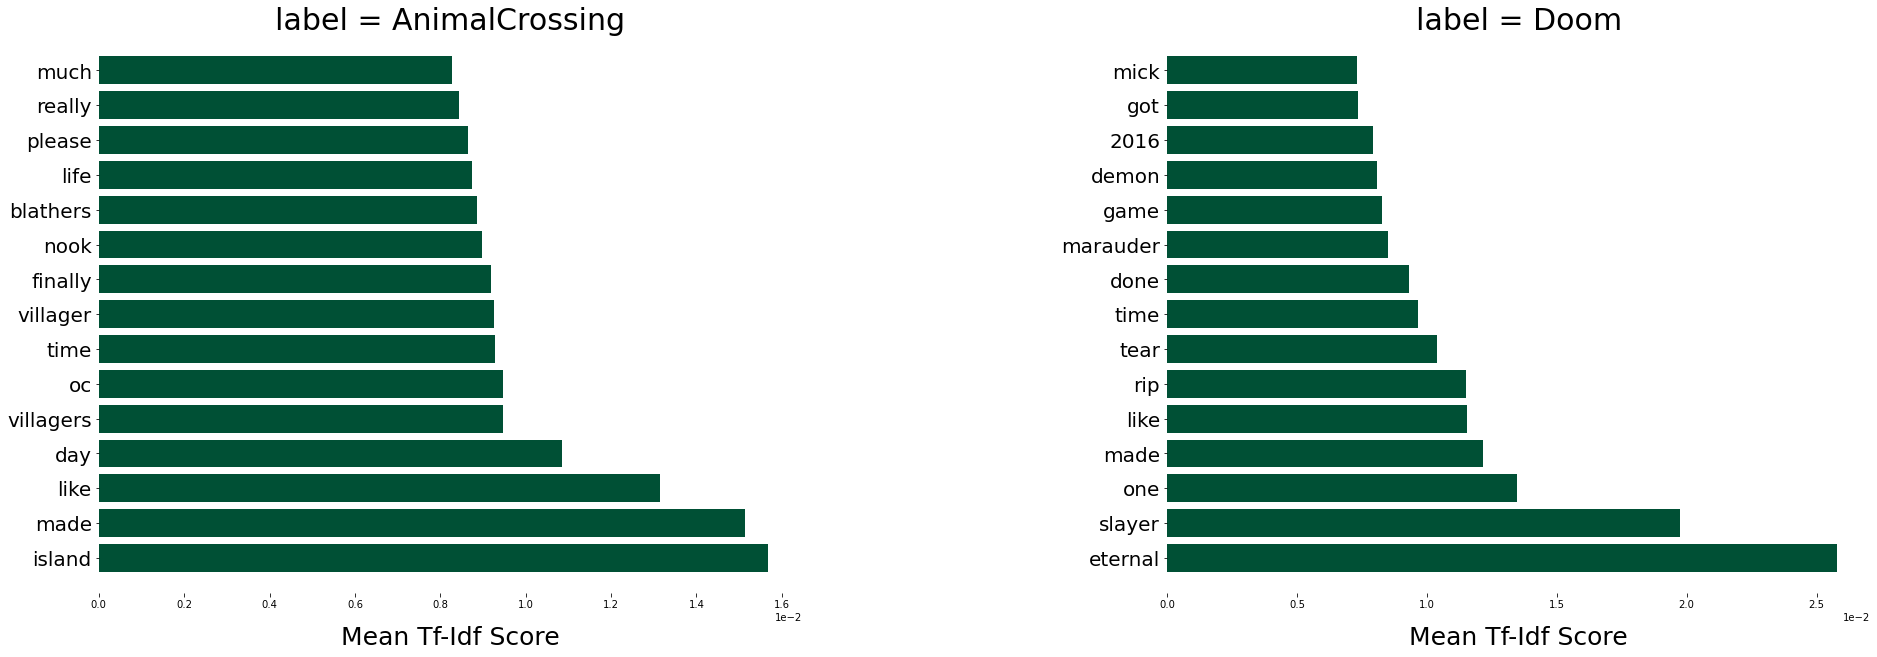

In [17]:
plot_tfidf_classfeats_h(dfs)

### Add the selected words as features in our training data for the model

In [18]:
train[['much','really','please','life','blathers','nook','finally','villager','time','oc','villagers','day','like','made','island','mick','got','2016','demon','game','marauder','done','tear','rip','one','slayer','eternal']] = tfidf_df[['much','really','please','life','blathers','nook','finally','villager','time','oc','villagers','day','like','made','island','mick','got','2016','demon','game','marauder','done','tear','rip','one','slayer','eternal']]

### Repeat the methodology for the testing set

In [19]:
tfidf_vector2 = tfidf_vectorizer.fit_transform(test['title'])
tfidf_vector2

<320x994 sparse matrix of type '<class 'numpy.float64'>'
	with 1525 stored elements in Compressed Sparse Row format>

In [20]:
tfidf_df2 = pd.DataFrame(tfidf_vector2.toarray(), columns=tfidf_vectorizer.get_feature_names())
tfidf_df2

,000,10,100,10000,1665,19,20,200,2014,2016,...,yeah,years,yeet,yes,yesterday,yet,zen,zombies,zoo,ウーフ
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
315,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
316,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
317,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
318,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
test[['much','really','please','life','blathers','nook','finally','villager','time','oc','villagers','day','like','made','island','mick','got','2016','demon','game','marauder','done','tear','rip','one','slayer','eternal']] = tfidf_df2[['much','really','please','life','blathers','nook','finally','villager','time','oc','villagers','day','like','made','island','mick','got','2016','demon','game','marauder','done','tear','rip','one','slayer','eternal']]

## Merge the predictions from Tensor Flow into the datasets

In [22]:
train = train.merge(train_pred,how='inner',left_on='filename',right_on='File')

In [23]:
test = test.merge(test_pred,how='inner',left_on='filename',right_on='File')

In [24]:
def Redefine(x):
    if x == 'AnimalCrossing':
        return(0)
    else:
        return(1)

In [25]:
train['subreddit'] = train['subreddit'].apply(lambda x: Redefine(x))
test['subreddit'] = test['subreddit'].apply(lambda x: Redefine(x))

In [26]:
train.head()

,Unnamed: 0,index,subreddit,id,title,ups,downs,upvote_ratio,total_awards_received,num_comments,...,marauder,done,tear,rip,one,slayer,eternal,File,AnimalCrossingWeights,DoomWeights
0,1148,699,0,fwoh0n,Oh no he has discovered my shrine!,12239,0,0.99,1,142,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,q5v956sajfr41.jpg,-0.275963,0.424229
1,1337,22,1,gh5puq,Not sure if this has been made before but...,12507,0,0.97,1,103,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,g0ffa5l44zx41.jpg,0.300478,-0.298994
2,1443,218,0,6564aw,"Hope you guys haven't seen this before, I thou...",28240,0,0.91,0,679,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,qavfy00f8cry.jpg,-0.244870,0.385208
3,868,127,0,g5681m,I recently found out that everybody hates Rodn...,37861,0,0.94,6,726,...,0.0,0.0,0.00000,0.000000,0.0,0.0,0.0,GP2Izrk.jpg,0.385279,-0.405017
4,1355,768,1,fnh8er,Rip and Tear,2533,0,1.00,0,88,...,0.0,0.0,0.71131,0.702879,0.0,0.0,0.0,c79oubyo5eo41.jpg,0.361384,-0.377136


Standardizing the data for the models

In [27]:
#Create function to standardize columns in the data set
def ZStandardize(array):
    if len(array.unique()) > 2:
        mean = array.mean()
        std = array.std()
        new_array = (array - mean)/std
        return(new_array)
    else:
        return(array)

In [28]:
train['ups']= ZStandardize(train['ups'])
test['ups']=ZStandardize(test['ups'])

train['downs']=ZStandardize(train['downs'])
test['downs']=ZStandardize(train['downs'])

train['total_awards_received']=ZStandardize(train['total_awards_received'])
test['total_awards_received']=ZStandardize(train['total_awards_received'])

train['num_comments']=ZStandardize(train['num_comments'])
test['num_comments']=ZStandardize(train['num_comments'])

In [29]:
train.describe()

,Unnamed: 0,index,subreddit,ups,downs,upvote_ratio,total_awards_received,num_comments,created_utc,much,...,game,marauder,done,tear,rip,one,slayer,eternal,AnimalCrossingWeights,DoomWeights
count,1276.000000,1276.000000,1276.000000,1.276000e+03,1276.0,1276.000000,1.276000e+03,1.276000e+03,1.276000e+03,1276.000000,...,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000,1276.000000
mean,796.785266,396.506270,0.525078,-1.306861e-16,0.0,0.979624,2.341387e-16,-3.567331e-17,1.583636e+09,0.005526,...,0.007600,0.004461,0.006470,0.005613,0.006039,0.011083,0.010391,0.013551,-0.053802,0.145277
std,461.939513,233.159319,0.499566,1.000000e+00,0.0,0.016934,1.000000e+00,1.000000e+00,9.696788e+06,0.052364,...,0.051907,0.044949,0.065253,0.055627,0.057035,0.063839,0.061396,0.071827,0.292062,0.366646
min,0.000000,1.000000,0.000000,-8.630959e-01,0.0,0.840000,-4.629612e-01,-8.990610e-01,1.492097e+09,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.281240,-0.408853
25%,394.750000,193.750000,0.000000,-7.726166e-01,0.0,0.970000,-4.629612e-01,-5.778391e-01,1.584654e+09,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.281240,-0.335883
50%,789.500000,395.500000,1.000000,-1.906486e-01,0.0,0.980000,-4.629612e-01,-2.872098e-01,1.586358e+09,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.280789,0.430327
75%,1203.500000,596.250000,1.000000,2.751651e-01,0.0,0.990000,1.614981e-01,1.917549e-01,1.588439e+09,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.332731,0.430935
max,1596.000000,838.000000,1.000000,5.230967e+00,0.0,1.000000,1.140176e+01,1.253490e+01,1.591278e+09,1.000000,...,0.584930,0.598156,1.000000,0.711310,0.702879,0.654745,0.536901,1.000000,0.386905,0.430935


# Modelling

In [30]:
x_train = train[['nook','finally','villager','time','oc','villagers','day','like','made','island','marauder','done','tear','rip','one','slayer','eternal','AnimalCrossingWeights', 'DoomWeights']]
y_train = train['subreddit']

In [31]:
x_test = test[['nook','finally','villager','time','oc','villagers','day','like','made','island','marauder','done','tear','rip','one','slayer','eternal','AnimalCrossingWeights', 'DoomWeights']]
y_test = test['subreddit']

### Random Forest

In [32]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

In [33]:
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

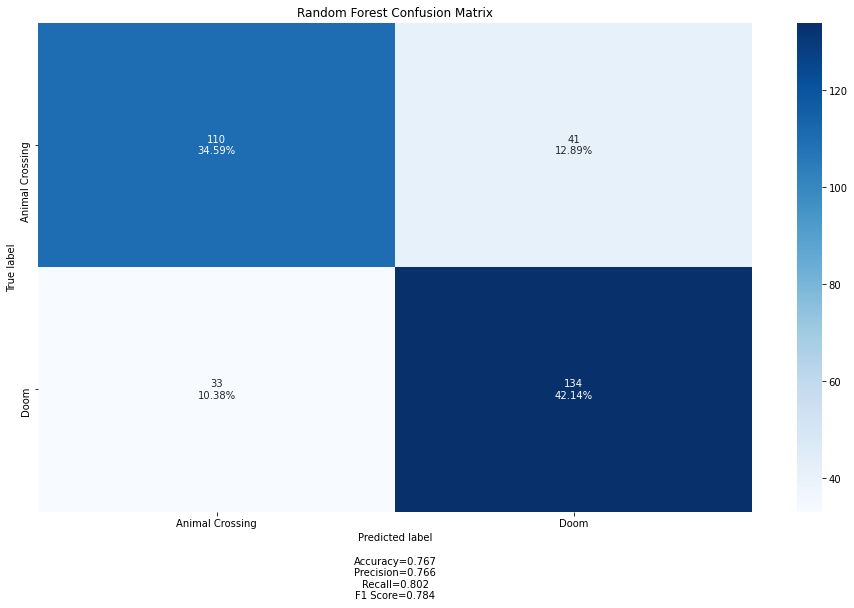

In [34]:
rf01 = RandomForestClassifier(n_estimators = 100,criterion="gini",random_state=7).fit(x_train,y_train)
prediction_rf01 = rf01.predict(x_test)

# Summary of the predictions made by the classifier
make_confusion_matrix(confusion_matrix(y_test,prediction_rf01),
                     title='Random Forest Confusion Matrix',
                     categories=['Animal Crossing','Doom'],
                     figsize=(16,9))

************* **Naive Bayes Model that is not  working with the negative weights** ********************************

nb = MultinomialNB().fit(x_train,y_train)
nb_predict = nb.predict(x_test)


print(classification_report(y_test, nb_predict))
print('Confusion Matrix')
print(confusion_matrix(y_test, nb_predict))

print('accuracy is',accuracy_score(nb_predict,y_test))

test_predictions_proba = nb.predict_proba(x_test)
ll = log_loss(y_test, test_predictions_proba)
print("Log Loss: {:.4}".format(ll))
print("="*30)

************* **Naive Bayes Model that is not  working with the negative weights** ********************************

### KNN

In [35]:
from sklearn.neighbors import KNeighborsClassifier

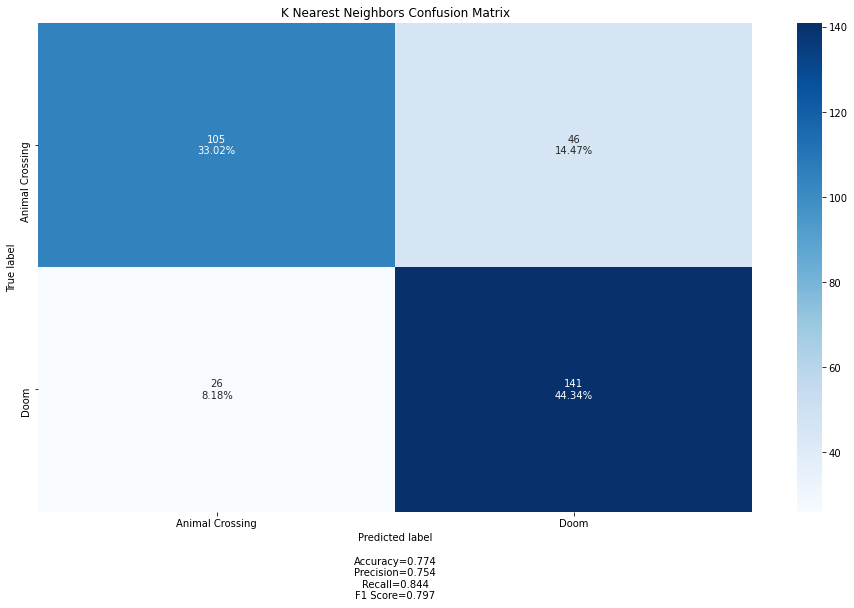

In [36]:
kn = KNeighborsClassifier().fit(x_train,y_train)
kn_predict = kn.predict(x_test)

make_confusion_matrix(confusion_matrix(y_test,kn_predict),
                     title='K Nearest Neighbors Confusion Matrix',
                     categories=['Animal Crossing','Doom'],
                     figsize=(16,9))

### SVM

In [37]:
from sklearn.svm import SVC

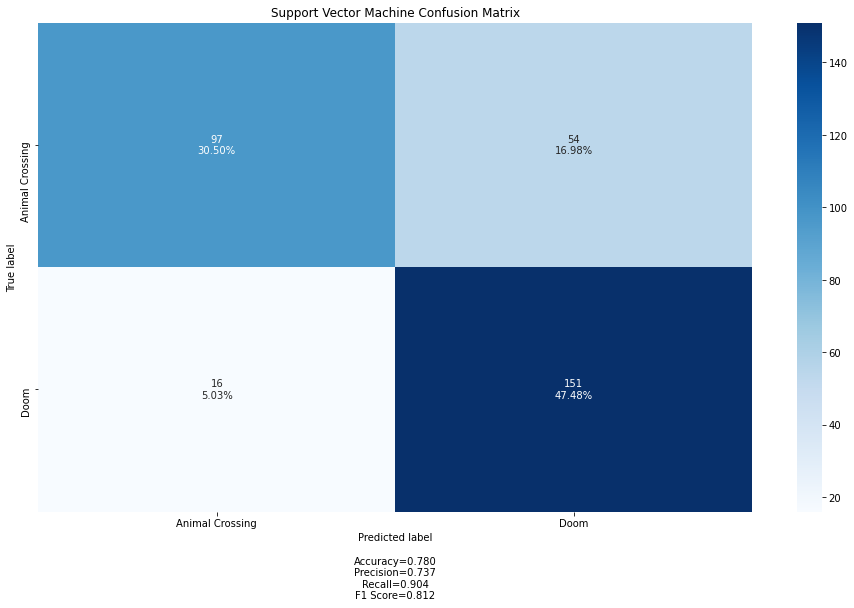

In [38]:
sv = SVC().fit(x_train,y_train)
sv_predict = sv.predict(x_test)

make_confusion_matrix(confusion_matrix(y_test,sv_predict),
                     title='Support Vector Machine Confusion Matrix',
                     categories=['Animal Crossing','Doom'],
                     figsize=(16,9))

### Gradient Boosting

In [39]:
from sklearn.ensemble import GradientBoostingClassifier

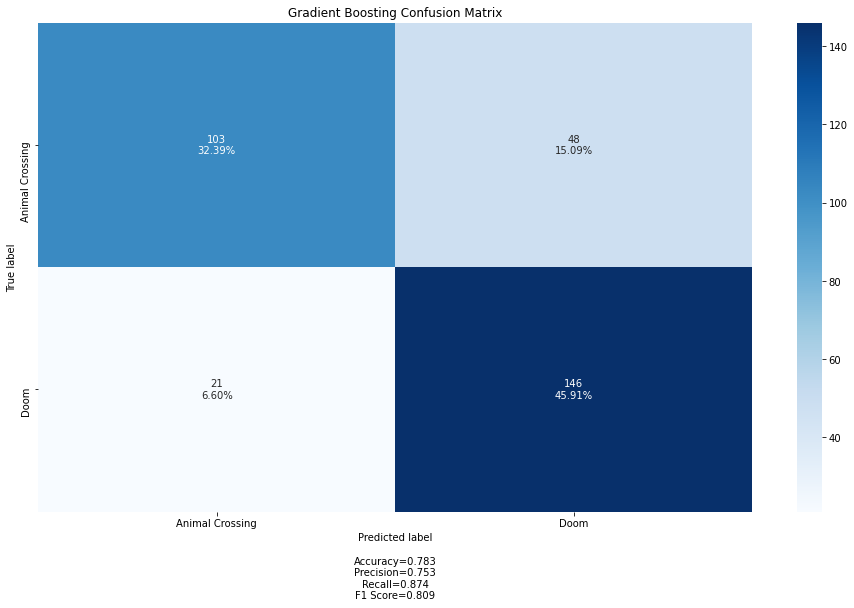

In [40]:
clf = GradientBoostingClassifier().fit(x_train,y_train)
predictions = clf.predict(x_test)

make_confusion_matrix(confusion_matrix(y_test,predictions),
                     title='Gradient Boosting Confusion Matrix',
                     categories=['Animal Crossing','Doom'],
                     figsize=(16,9))

### Logistic Regression

In [41]:
import statsmodels.api as sma

In [42]:
import statsmodels.api as sma
from sklearn.metrics import *
clf = sma.Logit(y_train,x_train).fit(method='bfgs')
print(clf.summary(),'\n')
predictions = clf.predict(x_test).apply(lambda x: round(x))
print(f'Accuracy of Logit model on validation set: {accuracy_score(y_test,predictions) *100}%')

         Current function value: 0.434939
         Iterations: 35
         Function evaluations: 37
         Gradient evaluations: 37
                           Logit Regression Results                           
Dep. Variable:              subreddit   No. Observations:                 1276
Model:                          Logit   Df Residuals:                     1257
Method:                           MLE   Df Model:                           18
Date:                Fri, 02 Dec 2022   Pseudo R-squ.:                  0.3714
Time:                        15:21:25   Log-Likelihood:                -554.98
converged:                      False   LL-Null:                       -882.85
Covariance Type:            nonrobust   LLR p-value:                1.380e-127
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
nook                     -5.3703      2.874     -1.869

C:\Users\sulli\anaconda3\lib\site-packages\statsmodels\base\model.py:566: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


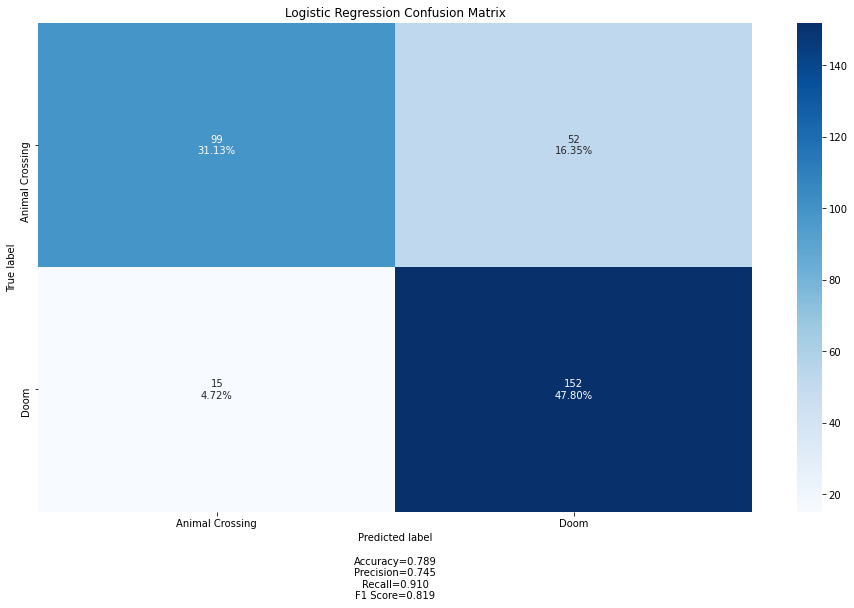

In [43]:
make_confusion_matrix(confusion_matrix(y_test,predictions),
                     title='Logistic Regression Confusion Matrix',
                     categories=['Animal Crossing','Doom'],
                     figsize=(16,9))

## Hyper-Parameter tuning
We'll be dong an extensive grid search to find the optimal parameters on our Gradient Boosting Classifier.

In [44]:
from sklearn.model_selection import GridSearchCV

In [46]:
from sklearn.model_selection import GridSearchCV
'''GB_params = {'n_estimators':[2,4,8,16,32,64,100,200],
             'learning_rate':[.01,.05,.1,.2,.5,1],
             'max_depth':[2,4,8,16,32,64,100,200]}
GB_grid_search = GridSearchCV(GradientBoostingClassifier(),param_grid=GB_params,
                              n_jobs=-1,cv=10,verbose=5)
GB_grid_search.fit(x_train,y_train)
print('Train Accuracy : %.3f'%GB_grid_search.best_estimator_.score(x_train,y_train))
print('Test Accuracy : %.3f'%GB_grid_search.best_estimator_.score(x_test,y_test))
print('Best Accuracy Through Grid Search : %.3f'%GB_grid_search.best_score_)
print('Best Parameters : ',GB_grid_search.best_params_)'''

Fitting 10 folds for each of 384 candidates, totalling 3840 fits
Train Accuracy : 0.851
Test Accuracy : 0.783
Best Accuracy Through Grid Search : 0.802
Best Parameters :  {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 200, 'random_state': 183}


Because grid search might take a while to run on some machines the image below has the output of the cell above.
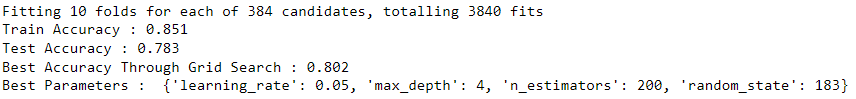

Let's evaluate the best gradient boosting model.

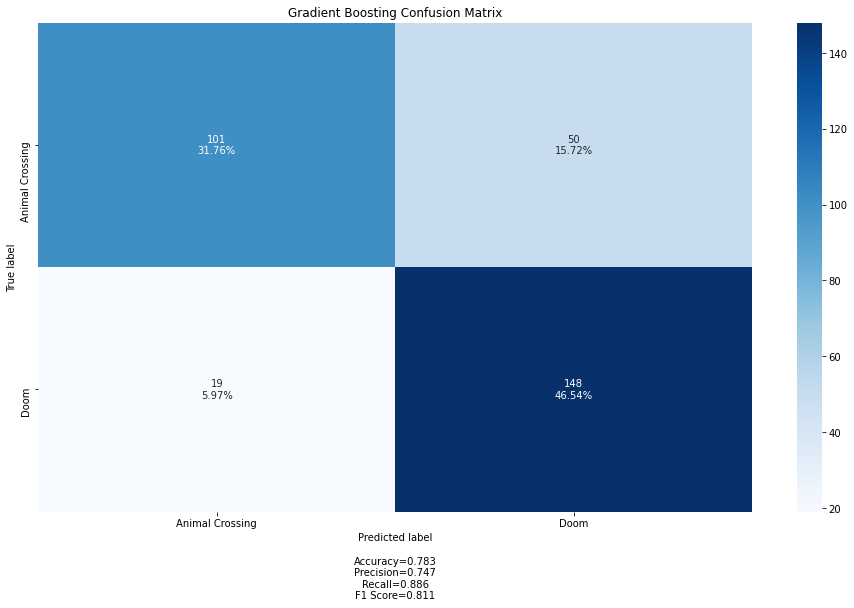

In [47]:
clf = GradientBoostingClassifier(learning_rate=.05,
                                max_depth=4,
                                n_estimators=200).fit(x_train,y_train)
predictions = clf.predict(x_test)

make_confusion_matrix(confusion_matrix(y_test,predictions),
                     title='Gradient Boosting Confusion Matrix',
                     categories=['Animal Crossing','Doom'],
                     figsize=(16,9))

Looking at this we'd want to utilize our logistic regression model. Let's analyze what our most important features are for the best gradient boosting model first.

<ipython-input-48-9dd481785533>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')


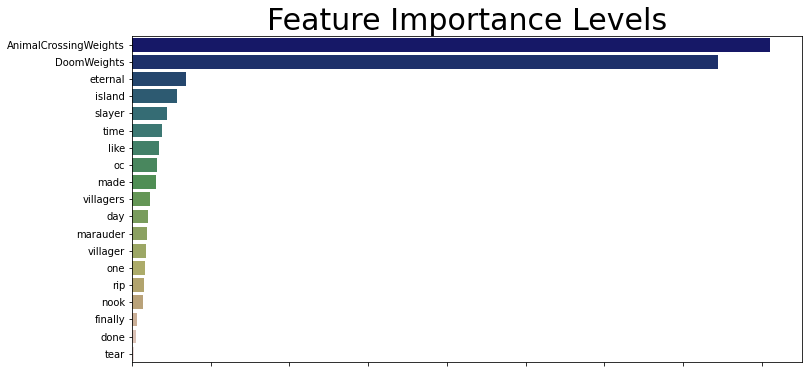

In [48]:
fi = clf.feature_importances_ #feature importance array
fi = pd.Series(data = fi, index = x_train.columns) #convert to Pandas series for plotting
fi.sort_values(ascending=False, inplace=True) #sort descending

#create bar plot
plt.figure(figsize=(12, 6))
plt.title('Feature Importance Levels',fontsize=30)
chart = sns.barplot(x=fi, y=fi.index, palette=sns.color_palette("gist_earth", n_colors=len(fi)))
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

# To do write about our best model and interpret results